# Generic LA tool

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from src.dlla.hw import dlla_p_gradient, prepare_traces_dl
from src.dlla.model9 import make_model_9
from src.dlla.wegener import make_mlp_wegener, wegener_p_gradient
from src.pollution.tools import file_suffix
from src.tools.lists import randomize
from src.tools.plotter import init_plots, plot_p_gradient, PALETTE_GRADIENT, store_sns, DLLA_PALETTE, TVLA_PALETTE
from src.trace_set.database import Database
from src.trace_set.set_hw import TraceSetHW
from src.tvla.cri import tvla_cri
from src.tvla.tvla import prepare_tvla, ASCAD_DEAD_TRACES, prune, Tvla, Group
from src.trace_set.transform import reduce_fixed_fixed, fixed_fixed

init_plots()

In [2]:
DB = Database.ascad

TRACE_SET = TraceSetHW(DB)

POLLUTION_TYPE = None
FILE_SUFFIX = file_suffix(POLLUTION_TYPE, 0)

NUM_CLASSES = 9

In [3]:
PROF_X, PROF_Y = TRACE_SET.profile()

In [4]:
PVS_CRI = tvla_cri(*prepare_tvla(PROF_X, PROF_Y), max_order=2, progress=False)

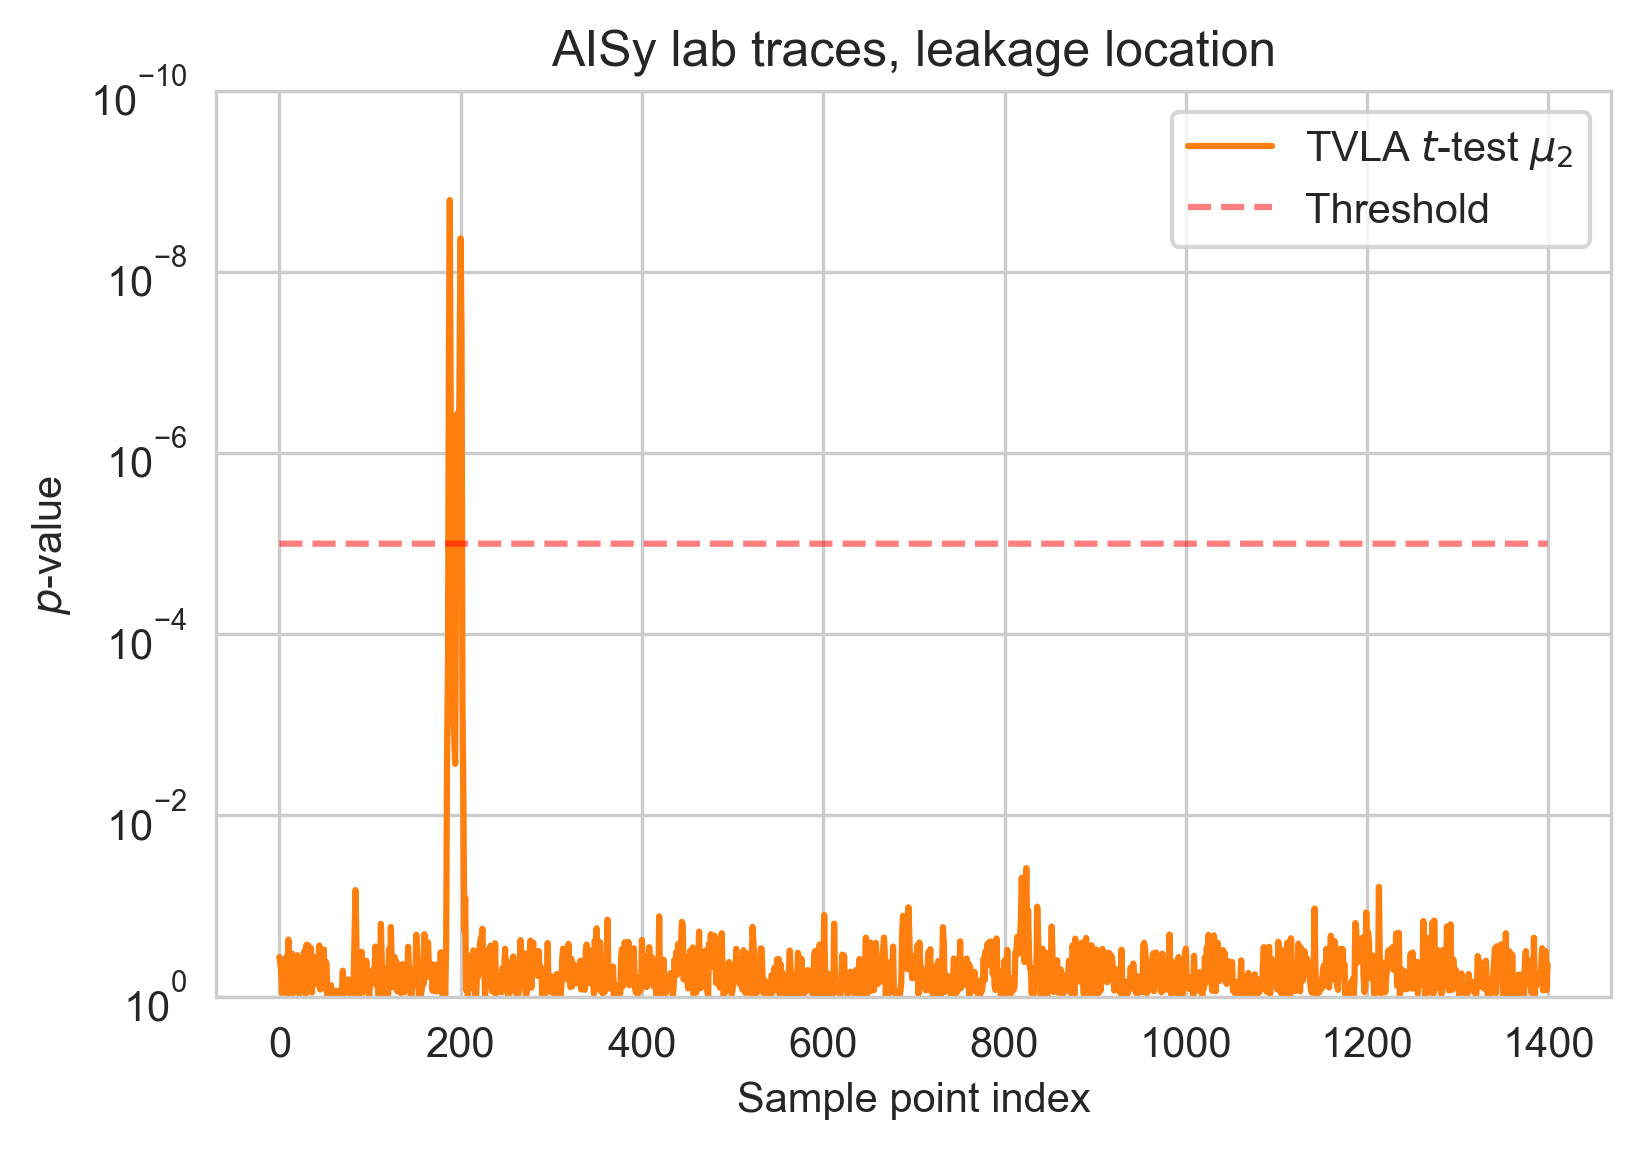

In [5]:
ORDER = 2

G = sns.lineplot(data={"TVLA $t$-test $\mu_2$": PVS_CRI[ORDER]}, palette=[TVLA_PALETTE[-1]])
sns.lineplot(data= [10 ** -5] * len(PVS_CRI[ORDER]), color="#FF000080", linestyle="--", label="Threshold")
G.invert_yaxis()
G.set(yscale="log", ylabel="$p$-value", xlabel="Sample point index", title="AISy lab traces, leakage location", ylim=(10 ** 0, 10 ** -10))
store_sns(G, f"{DB.name}-pvs-{FILE_SUFFIX}")

In [6]:
TITLE_SUB = f"Masked ASCAD traces with 1400 sample points"

In [7]:
def single_cri_p_gradient(x, y, min_pvs, order):
    _, min_sp = np.unravel_index(min_pvs.argmin(), min_pvs.shape)

    num_traces = len(x)
    num_points = 300
    start = 2

    x_lim = np.array(x[:, min_sp:min_sp + 1])
    x_lim, y = prune(x_lim, y, ASCAD_DEAD_TRACES)

    pvs = np.ones(num_points)

    point_ixs = np.linspace(start, num_traces, num_points).astype(int)

    for ix, limit in enumerate(point_ixs):
        pvs[ix] = np.min(tvla_cri(x_lim[:limit], y[:limit], max_order=order)[order])

    return np.interp(np.arange(num_traces), point_ixs, pvs)

def cri_p_gradient(x, y, min_pvs, order, times=20):
    res = []
    for _ in tqdm(range(times), "CRI p-gradient"):
        res.append(single_cri_p_gradient(*prepare_tvla(x, y), min_pvs, order))

    return np.mean(res, axis=0)

CRI_PG_1 = cri_p_gradient(PROF_X, PROF_Y, PVS_CRI, 1)
CRI_PG_2 = cri_p_gradient(PROF_X, PROF_Y, PVS_CRI, 2)
CRI_PG_3 = cri_p_gradient(PROF_X, PROF_Y, PVS_CRI, 3)

CRI p-gradient:   0%|          | 0/20 [00:00<?, ?it/s]/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:61: RuntimeWarning: Mean of empty slice.
  self.mean = traces.mean(axis=0)
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:80: RuntimeWarning: invalid value encountered in true_divide
  cm = np.sum(mean_free ** order, axis=0) / self.num_traces
CRI p-gradient: 100%|██████████| 20/20 [01:06<00:00,  3.32s/it]


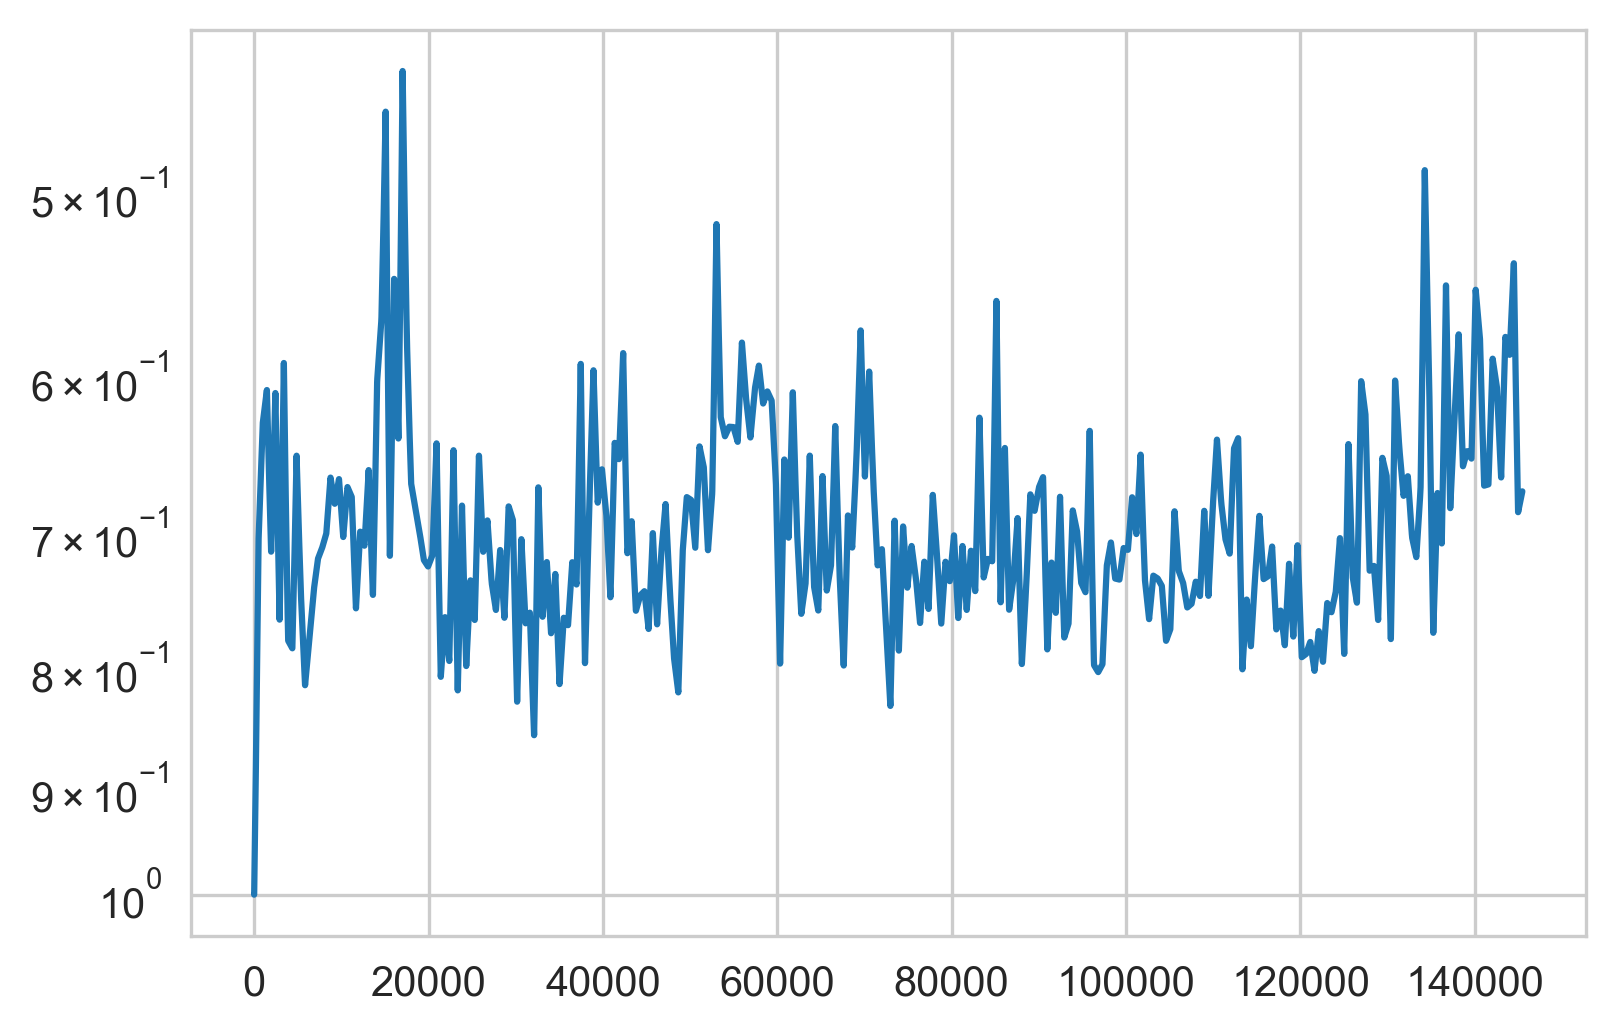

In [8]:
G = sns.lineplot(data=CRI_PG_1)
G.set(yscale='log') #, xlim=(94314,94320))
G.invert_yaxis()

In [9]:
X_ATT_ALL, Y_ATT_ALL = TRACE_SET.attack()
X, Y, X_ATT, Y_ATT = prepare_traces_dl(PROF_X, PROF_Y, X_ATT_ALL, Y_ATT_ALL)

0epoch [00:00, ?epoch/s]

/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


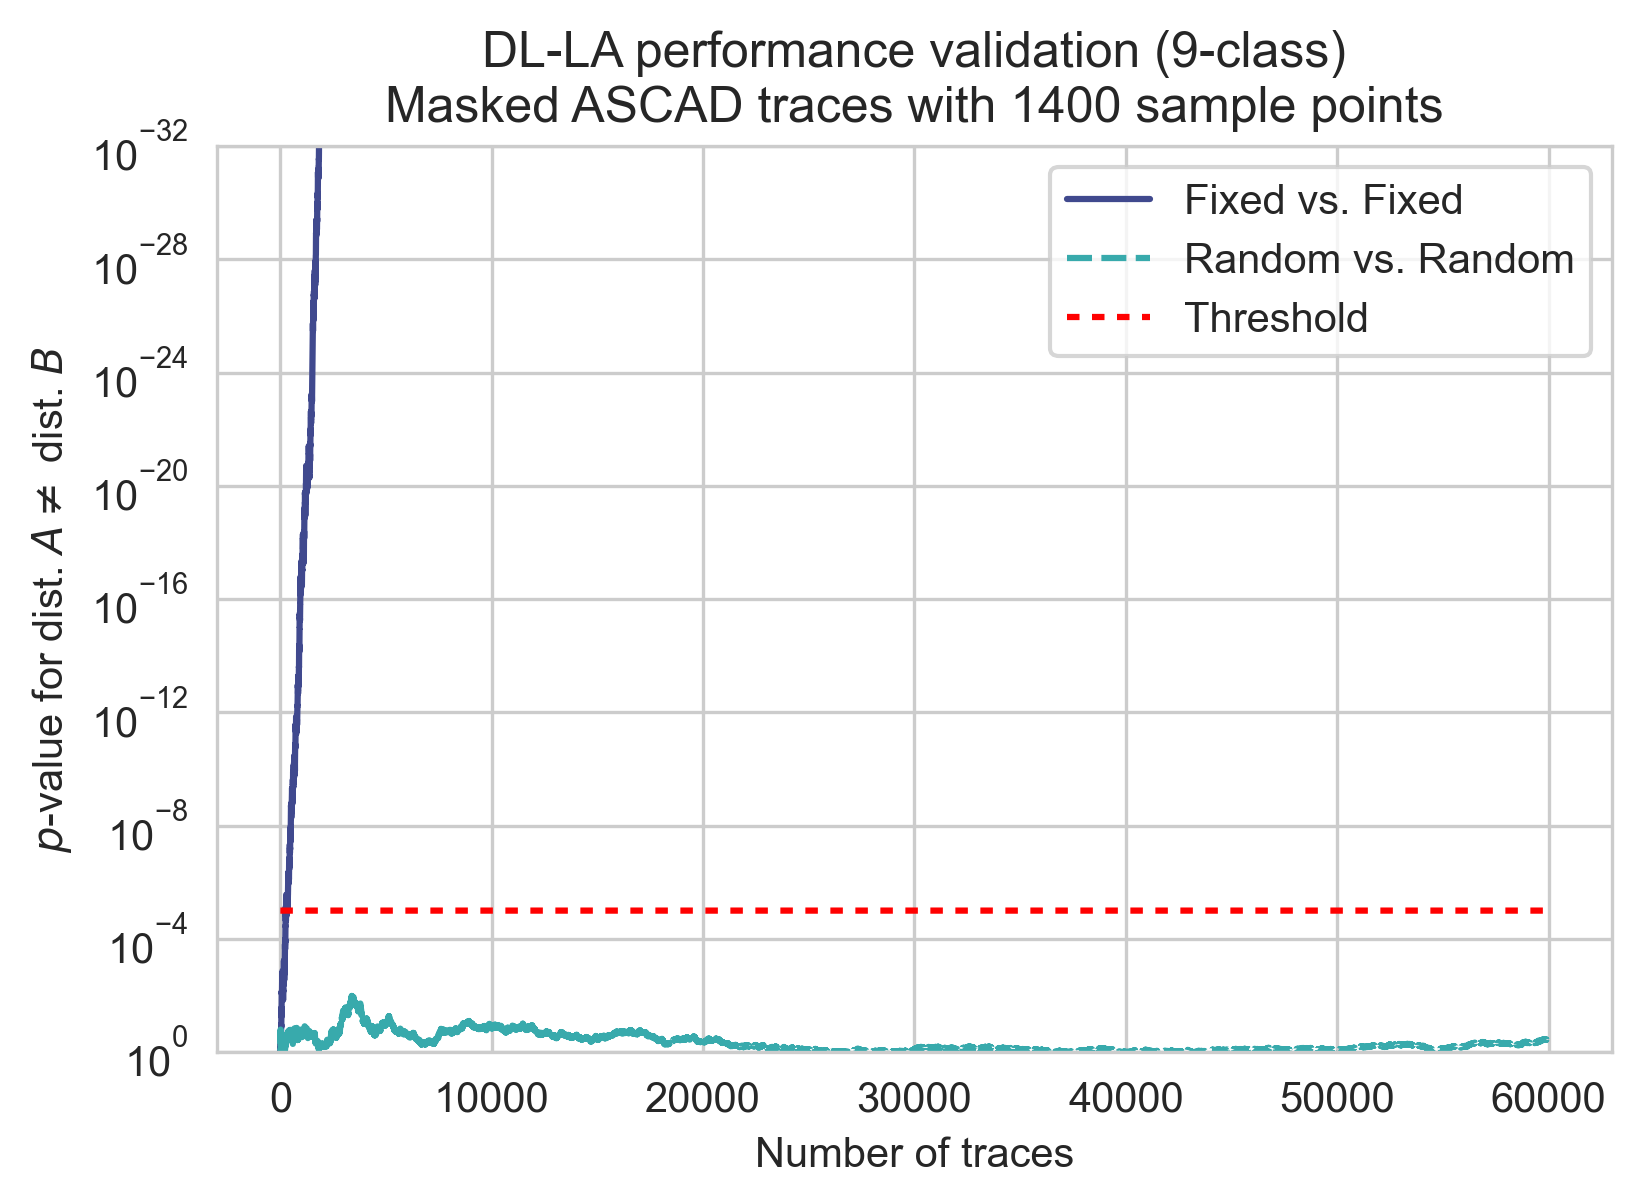

In [10]:
MODEL_9 = make_model_9(X, Y, X_ATT, Y_ATT)
PG_DLLA_9 = dlla_p_gradient(MODEL_9, X_ATT, Y_ATT)
PG_DLLA_9_RANDOM = dlla_p_gradient(MODEL_9, X_ATT, randomize(Y_ATT))

plot_p_gradient({
    "Fixed vs. Fixed": np.array(PG_DLLA_9)[:60000],
    "Random vs. Random": np.array(PG_DLLA_9_RANDOM)[:60000],
}, f"DL-LA performance validation (9-class)\n{TITLE_SUB}",
    palette=PALETTE_GRADIENT, file_name="ascad-validation-dlla9"
)

In [11]:
X_PROF_2, Y_PROF_2 = reduce_fixed_fixed(X, Y)
X_ATT_2, Y_ATT_2 = reduce_fixed_fixed(X_ATT, Y_ATT)
Y_ATT_2_RANDOM = randomize(Y_ATT_2)

Epoch 1/5
969/969 [==============================] - 2s 2ms/step - loss: 0.2499 - accuracy: 0.5324

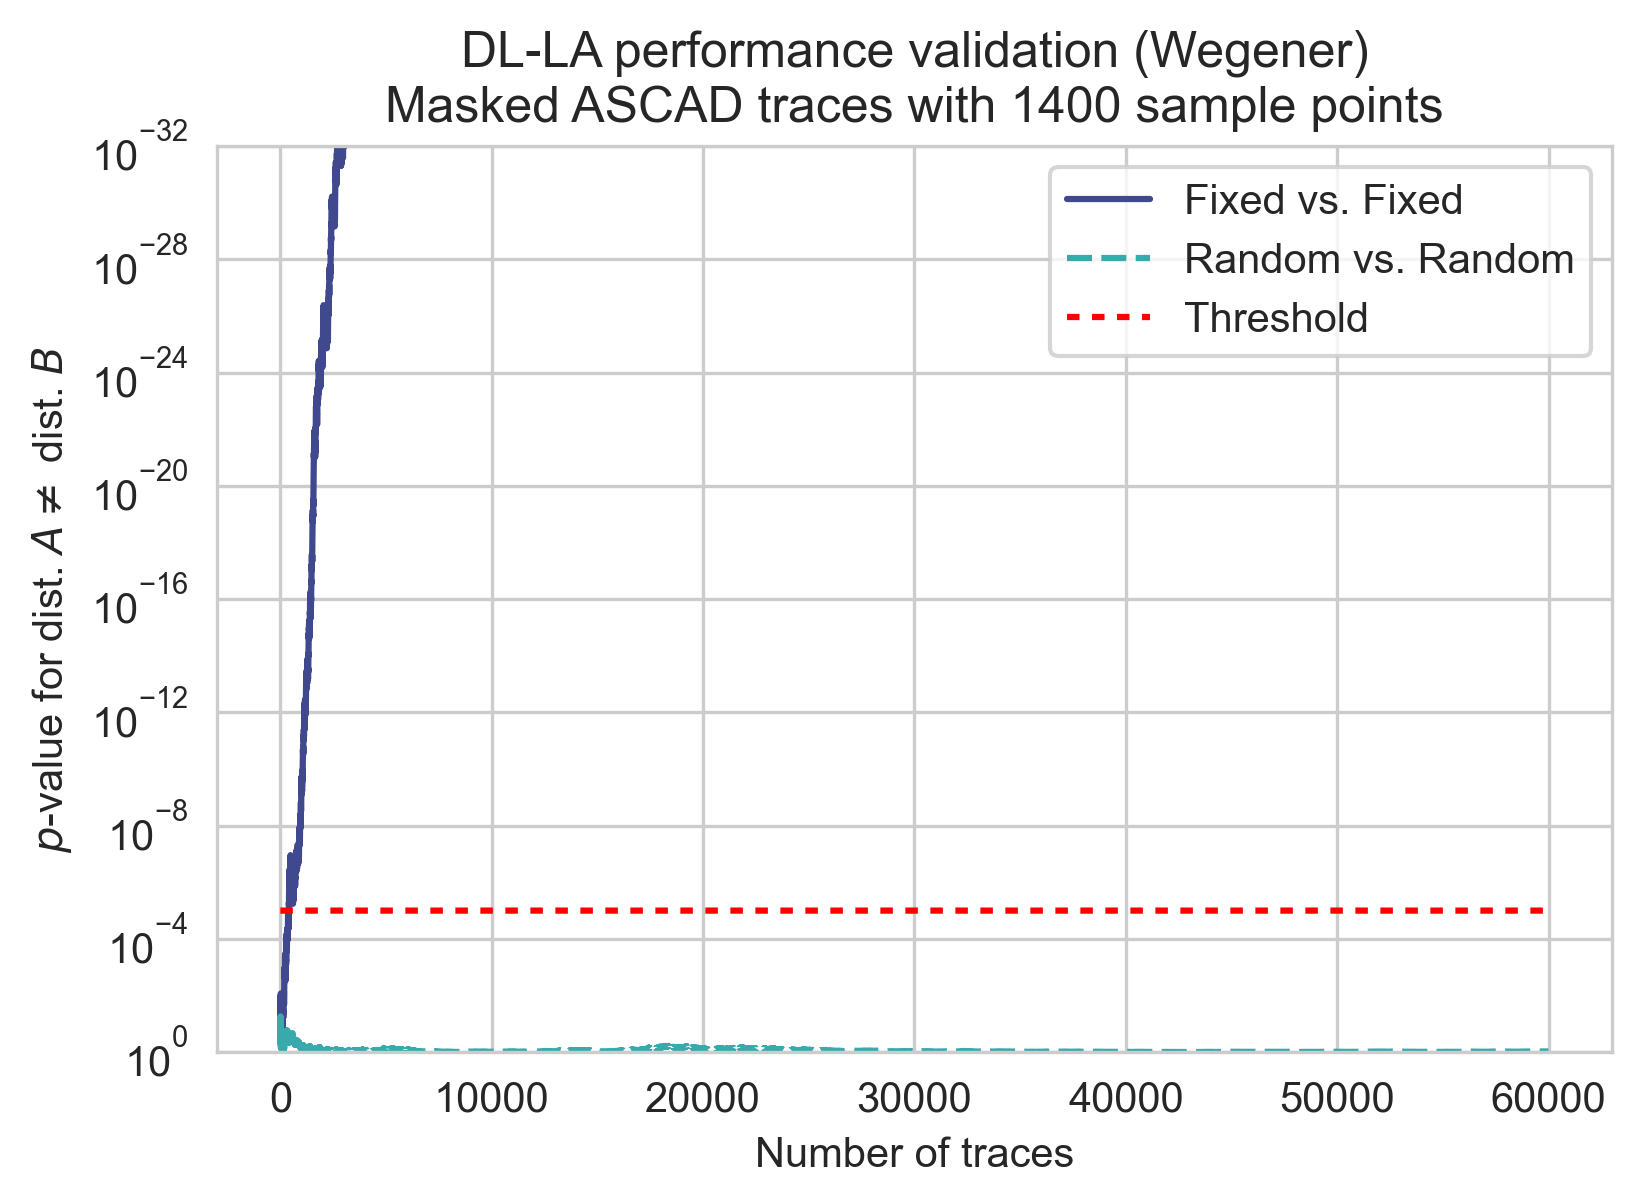

In [12]:
MODEL_WEGENER = make_mlp_wegener(X_PROF_2, Y_PROF_2)

PG_DLLA_2_AB = wegener_p_gradient(MODEL_WEGENER, X_ATT_2, Y_ATT_2)
PG_DLLA_2_RANDOM =  wegener_p_gradient(MODEL_WEGENER, X_ATT_2, Y_ATT_2_RANDOM)

plot_p_gradient({
    "Fixed vs. Fixed": np.array(PG_DLLA_2_AB)[:60000],
    "Random vs. Random": np.array(PG_DLLA_2_RANDOM)[:60000],
}, f"DL-LA performance validation (Wegener)\n{TITLE_SUB}",
    palette=PALETTE_GRADIENT, file_name="ascad-validation-wegener"
)

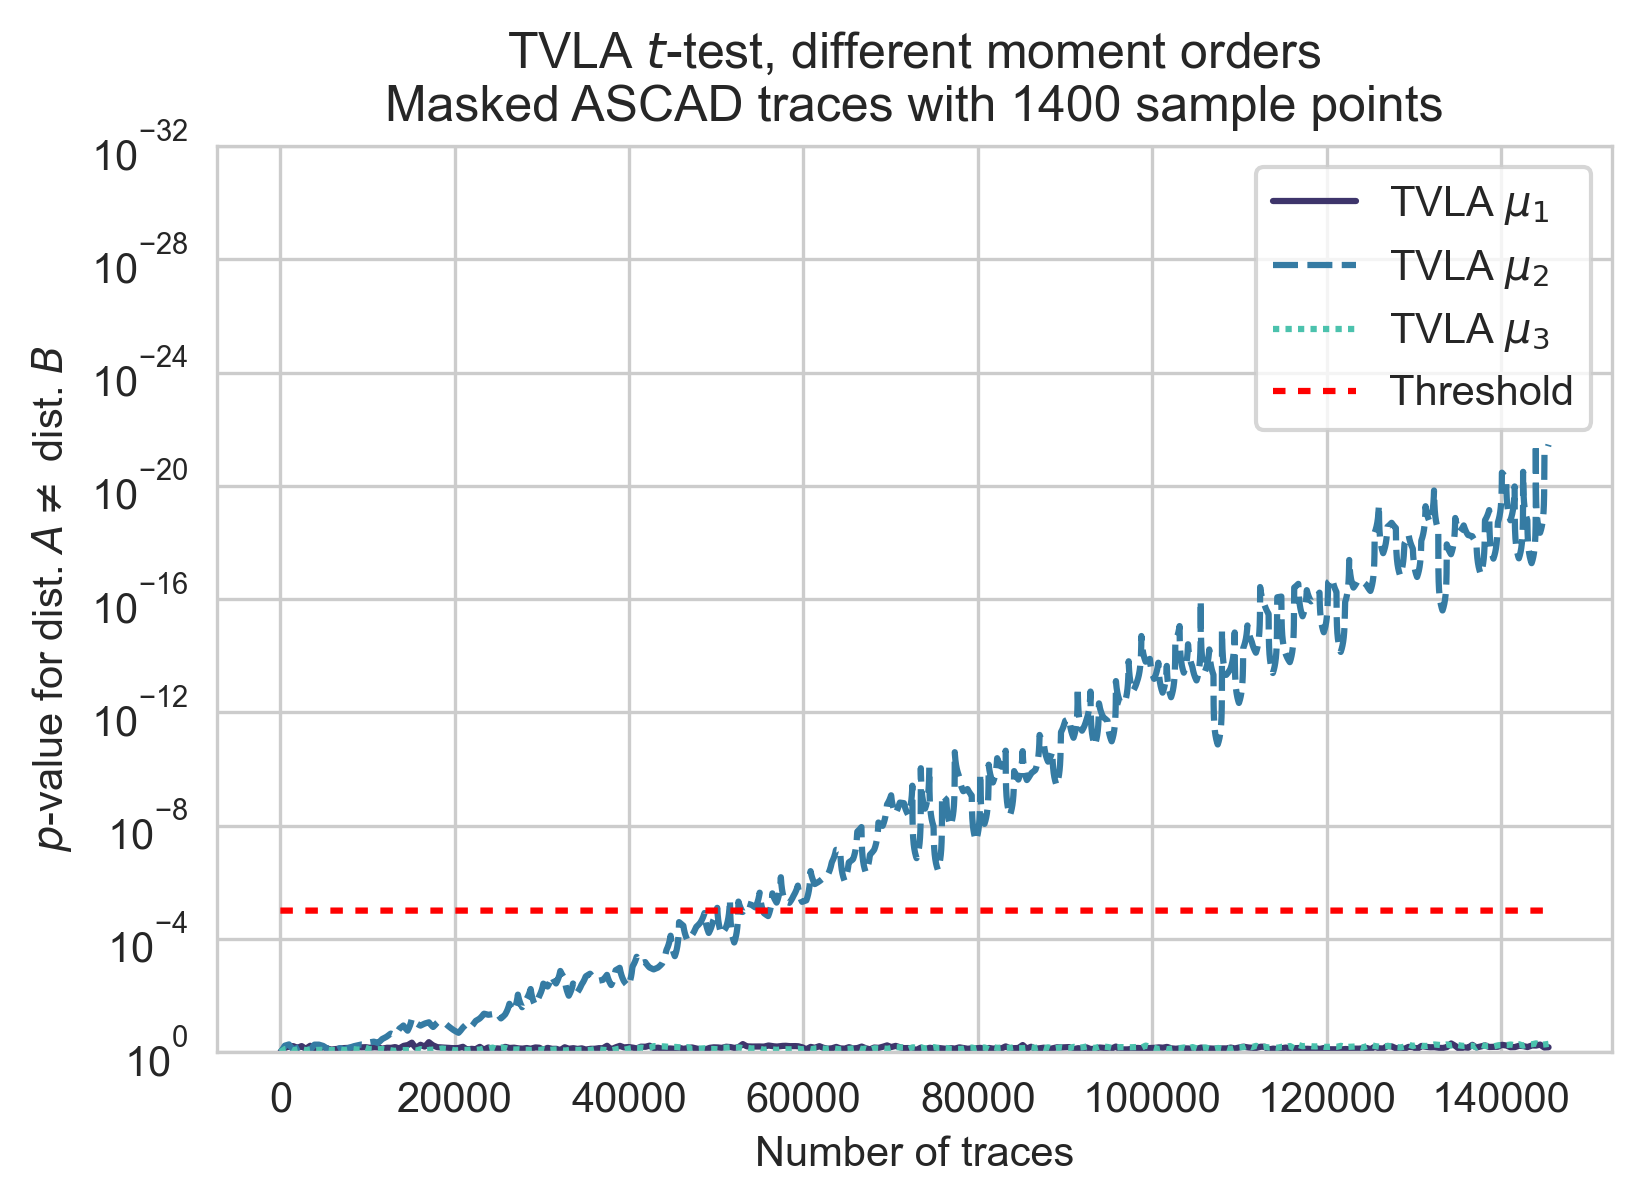

Exception: 

In [13]:
if POLLUTION_TYPE is None:
    TVLA_PGS = {
        "TVLA $\mu_1$": np.array(CRI_PG_1),
        "TVLA $\mu_2$": np.array(CRI_PG_2),
        "TVLA $\mu_3$": np.array(CRI_PG_3),
    }

    plot_p_gradient(TVLA_PGS, f"TVLA $t$-test, different moment orders\n{TITLE_SUB}", palette=PALETTE_GRADIENT, file_name=f"{DB.name}-tvla-orders")

    DF = pd.DataFrame(TVLA_PGS)
    DF.to_csv("tvla-p-gradient.csv")

In [ ]:
MAX_TRACE_SIZE = max(len(PG_DLLA_9), len(PG_DLLA_2_AB), len(CRI_PG_2))

COLOR_PALETTE = [DLLA_PALETTE[4], DLLA_PALETTE[2], TVLA_PALETTE[2]]

def expand(arr, max_len=MAX_TRACE_SIZE):
    return np.pad(arr, (0, max_len - len(arr)), 'constant', constant_values=np.nan)

PGS = {
    "DL-LA 9-class": expand(PG_DLLA_9),
    "DL-LA Wegener": expand(PG_DLLA_2_AB),
    "TVLA $t$-test, $\mu_2$": expand(CRI_PG_2),
}

plot_p_gradient(PGS, f"Method performance comparison\n{TITLE_SUB}", file_name=f"{DB.name}-all{FILE_SUFFIX}", palette=COLOR_PALETTE, max_traces=140000)

DF = pd.DataFrame(PGS)
DF.to_csv(f"{DB.name}-p-gradients{FILE_SUFFIX}.csv")

In [ ]:
PROF_Y_RANDOM = PROF_Y.copy()
np.random.shuffle(PROF_Y_RANDOM)

PGS_RANDOM_2 = cri_p_gradient(PROF_X, PROF_Y_RANDOM, tvla_cri(*prepare_tvla(PROF_X, PROF_Y_RANDOM), max_order=2, progress=False), 2)

In [ ]:
plot_p_gradient({
    "Fixed vs. Fixed": CRI_PG_2[:60000],
    "Random vs. Random": PGS_RANDOM_2[:60000],
}, f"TVLA CRI performance validation ($t$-test for $\\mu_2$)\n{TITLE_SUB}",
    palette=PALETTE_GRADIENT,
    file_name=f"{DB.name}-cri-tvla-validation-mu2")

In [ ]:
TVLA_MIN = Tvla(X.shape[1], max_order=2)

TVLA_MIN_RANDOM = Tvla(X.shape[1], max_order=2)
TVLA_X, TVLA_Y = prepare_tvla(PROF_X, PROF_Y)

A = TVLA_X[~TVLA_Y][:30000]
B = TVLA_X[TVLA_Y][:30000]

TVLA_PVS = np.array(Group(A, 2, True).t_test(Group(B, 2, True), 2))[1]

np.min(TVLA_PVS)

In [ ]:
np.random.shuffle(PROF_Y_RANDOM)
TVLA_X_RANDOM, TVLA_Y_RANDOM = prepare_tvla(PROF_X, PROF_Y_RANDOM)

A_RANDOM = TVLA_X[~TVLA_Y_RANDOM][:30000]
B_RANDOM = TVLA_X[TVLA_Y_RANDOM][:30000]

TVLA_PVS_RANDOM = np.array(Group(A_RANDOM, 2, False).t_test(Group(B_RANDOM, 2, False), 2))[1]

T_MIN = np.min(TVLA_PVS_RANDOM)
print(T_MIN)

In [ ]:
def tvla_p_gradient(a, b, min_pvs):
    min_pos = min_pvs.argmin()
    num_traces = min(len(a), len(b))

    start = 4
    order = 2
    num_points = 300
    pvs = np.ones(num_points)

    a_lim = a[:, min_pos:min_pos + 1]
    b_lim = b[:, min_pos:min_pos + 1]

    point_ixs = np.linspace(start, num_traces, num_points).astype(int)

    for ix, limit in tqdm(enumerate(point_ixs), total=num_points):
        pvs[ix] = Group(a_lim[:limit], order).t_test(Group(b_lim[:limit], order), order)[1]

    return np.interp(np.arange(num_traces), point_ixs, pvs)

PG_TVLA_2 = np.repeat(tvla_p_gradient(A, B, TVLA_PVS), 2)
PG_TVLA_2_RANDOM = np.repeat(tvla_p_gradient(A_RANDOM, B_RANDOM, TVLA_PVS), 2)

PG_TVLA_2

In [ ]:
plot_p_gradient({
    "Fixed vs. Fixed": PG_TVLA_2,
    "Random vs. Random": PG_TVLA_2_RANDOM,
}, f"TVLA performance validation ($t$-test for $\\mu_2$)\n{TITLE_SUB}",
    palette=PALETTE_GRADIENT,
    file_name=f"{DB.name}-tvla-validation-mu2")

In [ ]:
PGS = {
    "DL-LA 9-class": expand(PG_DLLA_9),
    "DL-LA Wegener": expand(PG_DLLA_2_AB),
    "TVLA $t$-test, $\mu_2$": expand(CRI_PG_2),
}

DF = pd.DataFrame(PGS)
DF.to_csv("dlla-p-gradient.csv")
plot_p_gradient(PGS, "LA method performance\nmasked AES with 1400 sample points",
    palette=COLOR_PALETTE, file_name="ascad-default-dlla-1000", max_traces=1000
)